In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.patches as mpatches

pd.set_option('display.max_columns', None)

In [2]:
operations = pd.read_csv('data/operations/operations_cleaned.csv', low_memory=False)
weapons = pd.read_csv('data/operations/weapon.csv', encoding='latin-1')
aircrafts = pd.read_csv('data/operations/aircraft.csv', encoding='latin-1')

# Purpose of this note book: Implmenting Risk Assessment Model
In this notebook, I will implement a hierachical risk assessment model for 3 levels:
1. Level-1/ADM1: Is the top level with summarized statistics of every province/cities.
2. Level-2/ADM2: Is the sub-level of ADM1 which contains statistics of every districts inside a province/city.
3. 10km2 grids: Is the smallest unit level in this model, and is the sub-level of ADM2 which contains statistics of 10km2 square grid.

# 1. Data processing

In [95]:
operations = pd.read_csv('data/operations/operations_cleaned.csv', low_memory=False)

In [3]:
aircrafts = pd.read_csv('data/operations/weapon.csv', encoding='latin-1')
weapons = pd.read_csv('data/operations/weapon.csv', encoding='latin-1')

In [19]:
dud_rate = pd.read_csv('data/dud_rate.csv')

In [11]:
adm0 = gpd.read_file('data/geoborders/adm0/geoBoundaries-VNM-ADM0.geojson')
adm1 = gpd.read_file('data/geoborders/adm1/geoBoundaries-VNM-ADM1.geojson')
adm2 = gpd.read_file('data/geoborders/adm2/geoBoundaries-VNM-ADM2.geojson')

C:\Users\dummy\miniconda3\envs\deep-learning\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


In [98]:
operations = operations.rename(columns = {
    'TGTLONDDD_DDD_WGS84' : 'lon',
    'TGTLATDD_DDD_WGS84' : 'lat'
})

In [99]:
operations = operations.dropna(subset=['lon'])

In [100]:
original_selected_columns = [
    'lon', 'lat', 'MSNDATE', 'NUMWEAPONSDELIVERED', 'TGTWEATHER', 'WEAPONTYPE',
    'MFUNC_DESC', 'MFUNC_DESC_CLASS', 'WEAPONTYPEWEIGHT'
]

In [101]:
operations = operations[original_selected_columns]

In [102]:
weapon_class = weapons[['WEAPONTYPE', 'WEAPON_CLASS']]
operations = operations.merge(weapon_class, 'left', 'WEAPONTYPE')

#### Adding GeoData to operations and remove data points outside range of 5km away from border

In [104]:
geometry = [Point(xy) for xy in zip(operations['lon'], operations['lat'])]
gdf = gpd.GeoDataFrame(operations, geometry=geometry, crs='EPSG:4326')

In [105]:
from shapely.ops import unary_union, nearest_points

gdf = gdf.to_crs(epsg=32648)
adm0 = adm0.to_crs(epsg=32648)

adm0_union = unary_union(adm0.geometry)

adm0_buffer = adm0_union.buffer(5000)

adm0_boundary = adm0_union.boundary

gdf_filtered = gdf[gdf.geometry.within(adm0_buffer)]

outside_mask = ~gdf_filtered.geometry.within(adm0_union)

gdf_filtered.loc[outside_mask, 'geometry'] = gdf_filtered.loc[outside_mask, 'geometry'].apply(
    lambda geom: nearest_points(geom, adm0_boundary)[1]
)

gdf_filtered = gdf_filtered.to_crs(epsg=4326)
operations = gdf_filtered

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
print(operations.columns)

In [ ]:
operations = operations.merge(dud_rate[['WEAPONTYPE', 'DUD_RATE']], 'left', 'WEAPONTYPE')

In [25]:
operations['DUD_RATE'] /= 100


In [ ]:
operations['DUD_NUMWEAPONSDELIVERED'] = operations['DUD_RATE'] * operations['NUMWEAPONSDELIVERED']

#### Spatial joining ADM0, ADM1, and ADM2

In [17]:
import geopandas as gpd

# Ensure all GeoDataFrames use the same CRS
operations = operations.to_crs(adm2.crs)  # adm1 and adm0 should have same CRS as adm2

target_crs = operations.crs

adm0 = adm0.to_crs(target_crs)
adm1 = adm1.to_crs(target_crs)
adm2 = adm2.to_crs(target_crs)

# Merge with ADM2 (e.g., districts)
operations = gpd.sjoin(operations, adm2[['shapeName', 'shapeID', 'geometry']], how='left', predicate='within')
operations = operations.rename(columns={'shapeName': 'ADM2_name', 'shapeID': 'ADM2_id'})
operations = operations.drop(columns='index_right')

# Merge with ADM1 (e.g., provinces)
operations = gpd.sjoin(operations, adm1[['shapeName', 'shapeID', 'geometry']], how='left', predicate='within')
operations = operations.rename(columns={'shapeName': 'ADM1_name', 'shapeID': 'ADM1_id'})
operations = operations.drop(columns='index_right')

# Merge with ADM0 (country level)
operations = gpd.sjoin(operations, adm0[['shapeName', 'shapeID', 'geometry']], how='left', predicate='within')
operations = operations.rename(columns={'shapeName': 'ADM0_name', 'shapeID': 'ADM0_id'})
operations = operations.drop(columns='index_right')

In [18]:
operations.columns

Index(['lon', 'lat', 'MSNDATE', 'NUMWEAPONSDELIVERED', 'TGTWEATHER',
       'WEAPONTYPE', 'MFUNC_DESC', 'MFUNC_DESC_CLASS', 'WEAPONTYPEWEIGHT',
       'WEAPON_CLASS', 'geometry', 'DUD_RATE', 'DUD_NUMWEAPONSDELIVERED',
       'ADM2_name', 'ADM2_id', 'ADM1_name', 'ADM1_id', 'ADM0_name', 'ADM0_id'],
      dtype='object')

In [19]:
# operations.to_csv('analysis/data/operations_dud_rate.csv', index=False)

# If operations_dud_Rate.csv already exist run from here

In [4]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import numpy as np
import jenkspy
from shapely import Point

In [2]:
operations = pd.read_csv('analysis/data/operations_dud_rate.csv', low_memory=False)
operations['geometry'] = operations['geometry'].apply(wkt.loads)

operations_gdf = gpd.GeoDataFrame(operations, geometry='geometry')

operations = operations_gdf.set_crs(epsg=4326, inplace=True)

In [5]:
# Reproject to metric CRS (UTM Zone 48N)
operations_utm = operations.to_crs(epsg=32648)

# Define grid size for 10 km² area grid
grid_size = np.sqrt(10) * 1000  # ≈3162 meters

# Calculate grid indices
operations_utm['grid_x'] = (operations_utm.geometry.x // grid_size).astype(int)
operations_utm['grid_y'] = (operations_utm.geometry.y // grid_size).astype(int)

# Calculate center coordinates for each grid cell
operations_utm['grid_center_x'] = (operations_utm['grid_x'] + 0.5) * grid_size
operations_utm['grid_center_y'] = (operations_utm['grid_y'] + 0.5) * grid_size

# Create grid center point geometry in UTM CRS
grid_centers_utm = gpd.GeoSeries(
    [Point(xy) for xy in zip(operations_utm['grid_center_x'], operations_utm['grid_center_y'])],
    crs='EPSG:32648'
)

# Convert grid center points back to WGS84 for plotting
grid_centers_wgs84 = grid_centers_utm.to_crs(epsg=4326)

# Extract lat/lon for grid center
operations_utm['grid_center_lon'] = grid_centers_wgs84.x
operations_utm['grid_center_lat'] = grid_centers_wgs84.y

# Create grid ID
operations_utm['grid_id'] = operations_utm['grid_x'].astype(str) + '_' + operations_utm['grid_y'].astype(str)

# Optional: convert full GeoDataFrame back to WGS84 for export or visualization
operations_with_grid = operations_utm.to_crs(epsg=4326)

In [6]:
print("Number of 10km2 squares that is possibly contaiminated")
print(len(operations_with_grid['grid_id'].unique())) 
print(len(operations_with_grid['grid_center_lat'].unique()))

Number of 10km2 squares that is possibly contaiminated
25399
25399


In [7]:
operations_with_grid = operations_with_grid.drop(columns=['grid_x','grid_y', 'lon', 'lat',
                                                         'TGTWEATHER', 'WEAPONTYPEWEIGHT',
                                                          'grid_center_x', 'grid_center_y'])

In [8]:
# operations_with_grid.to_csv('analysis/data/operations_dud_rate_gridded.csv', index=False)

In [9]:
operations_with_grid.columns

Index(['MSNDATE', 'NUMWEAPONSDELIVERED', 'WEAPONTYPE', 'MFUNC_DESC',
       'MFUNC_DESC_CLASS', 'WEAPON_CLASS', 'geometry', 'DUD_RATE',
       'DUD_NUMWEAPONSDELIVERED', 'ADM2_name', 'ADM2_id', 'ADM1_name',
       'ADM1_id', 'ADM0_name', 'ADM0_id', 'grid_center_lon', 'grid_center_lat',
       'grid_id'],
      dtype='object')

#### A grid belongs to an adm2 if the center of grid is inside that ADM2

In [13]:
# 1. Extract unique grid center coordinates
grid_centers_df = operations_with_grid[['grid_id', 'grid_center_lon', 'grid_center_lat']].drop_duplicates()

# 2. Convert to GeoDataFrame (WGS84)
grid_centers_gdf = gpd.GeoDataFrame(
    grid_centers_df,
    geometry=gpd.points_from_xy(grid_centers_df['grid_center_lon'], grid_centers_df['grid_center_lat']),
    crs='EPSG:4326'
)

# 3. Spatial join with ADM2 to get both name and ID
grid_to_adm2 = gpd.sjoin(
    grid_centers_gdf,
    adm2[['shapeName', 'shapeID', 'geometry']],
    how='left',
    predicate='within'
)

# 4. Rename columns for consistency
grid_to_adm2 = grid_to_adm2.rename(columns={
    'shapeName': 'ADM2_name',
    'shapeID': 'ADM2_id'  # Match original column name
})

# 5. Spatial join with ADM1 to get ADM1 information
grid_to_adm1 = gpd.sjoin(
    grid_centers_gdf,
    adm1[['shapeName', 'shapeID', 'geometry']],
    how='left',
    predicate='within'
)

# 6. Rename ADM1 columns for consistency
grid_to_adm1 = grid_to_adm1.rename(columns={
    'shapeName': 'ADM1_name',
    'shapeID': 'ADM1_id'  # Match original column name
})

# 7. Combine ADM1 and ADM2 information
grid_adm_mapping = grid_centers_gdf[['grid_id']].merge(
    grid_to_adm1[['grid_id', 'ADM1_name', 'ADM1_id']],
    on='grid_id',
    how='left'
).merge(
    grid_to_adm2[['grid_id', 'ADM2_name', 'ADM2_id']],
    on='grid_id',
    how='left'
)

# 8. Ensure each grid_id has only one set of ADM values (in case of duplicates)
grid_adm_mapping_unique = grid_adm_mapping.drop_duplicates(subset=['grid_id'], keep='first')

# 9. Create a clean version of operations_with_grid
# First, drop the existing ADM columns that we want to replace
operations_with_grid_temp = operations_with_grid.drop(columns=[
    'ADM1_name', 'ADM1_id', 'ADM2_name', 'ADM2_id'
])

# Then merge with the new unique mapping
operations_with_grid_clean = operations_with_grid_temp.merge(
    grid_adm_mapping_unique[['grid_id', 'ADM1_name', 'ADM1_id', 'ADM2_name', 'ADM2_id']],
    on='grid_id',
    how='left'
)

In [14]:
operations_with_grid_clean.columns

Index(['MSNDATE', 'NUMWEAPONSDELIVERED', 'WEAPONTYPE', 'MFUNC_DESC',
       'MFUNC_DESC_CLASS', 'WEAPON_CLASS', 'geometry', 'DUD_RATE',
       'DUD_NUMWEAPONSDELIVERED', 'ADM0_name', 'ADM0_id', 'grid_center_lon',
       'grid_center_lat', 'grid_id', 'ADM1_name', 'ADM1_id', 'ADM2_name',
       'ADM2_id'],
      dtype='object')

In [15]:
# operations_with_grid_clean.to_csv('analysis/data/operation_dud_rate_gridded_adm2.csv', index=False)

# 2. Implementing Risk Assessment Model

## 2.1. Additional data processing

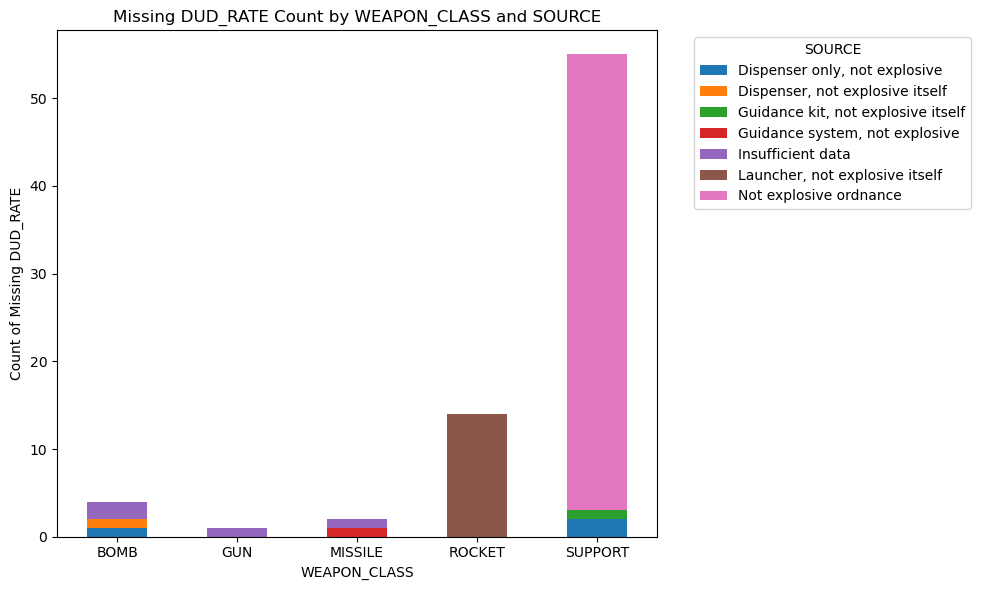

In [90]:
# Filter rows with missing DUD_RATE
missing_df = dud_rate[dud_rate['DUD_RATE'].isna()]

# Count missing by WEAPON_CLASS and SOURCE
missing_counts = missing_df.groupby(['WEAPON_CLASS', 'SOURCE']).size().unstack(fill_value=0)

missing_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xticks(rotation=0)  # Keep labels horizontal

plt.title('Missing DUD_RATE Count by WEAPON_CLASS and SOURCE')
plt.xlabel('WEAPON_CLASS')
plt.ylabel('Count of Missing DUD_RATE')
plt.legend(title='SOURCE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [89]:
dud_rate

,WEAPONTYPE,WEAPONTYPE_COMMON_NAME,WEAPON_CLASS,DUD_RATE,SOURCE
0,100 GP,General Purpose Bomb,BOMB,0.100,"US DoD UXO Technical Report, 1970"
1,1000 G,Megaboller flash powder bomb,BOMB,0.035,"Military Munitions Assessment Report, 1975"
2,1000LB GP M-65,An-M65,BOMB,0.100,"USAF Explosive Ordnance Report, 1972"
3,1000LB MK-83,Mark 83 bomb,BOMB,0.057,"Naval Weapons Center Study, 1974"
4,1000LB SAP M59,AN-M59,BOMB,0.120,"USAF EOD Historical Analysis, 1973"
...,...,...,...,...,...
289,XM384 40MM AMMO,NaN,SUPPORT,NaN,Not explosive ordnance
290,XM40E5,XM40E5 Gravel Bomb,MISSILE,0.200,"Cluster Munitions Assessment Report, 1975"
291,XM41UNITS-CAN,NaN,MISSILE,NaN,Insufficient data
292,XM42 (XM12) GRVL BOMB,NaN,MISSILE,0.200,"Cluster Munitions Assessment Report, 1975"


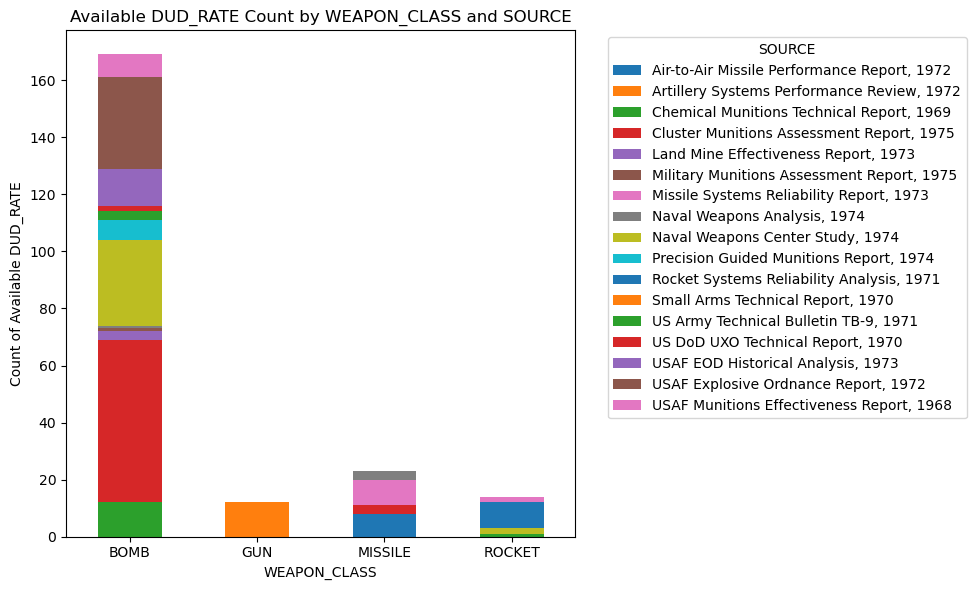

In [91]:
# Filter rows with available DUD_RATE
available_df = dud_rate[dud_rate['DUD_RATE'].notna()]

# Count available by WEAPON_CLASS and SOURCE
available_counts = available_df.groupby(['WEAPON_CLASS', 'SOURCE']).size().unstack(fill_value=0)

# Plot stacked bar chart
available_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xticks(rotation=0)  # Keep labels horizontal

plt.title('Available DUD_RATE Count by WEAPON_CLASS and SOURCE')
plt.xlabel('WEAPON_CLASS')
plt.ylabel('Count of Available DUD_RATE')
plt.legend(title='SOURCE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Base on this graph, we can remove support missions

#### Group data by grid ID

In [26]:
operations_with_grid_clean = operations_with_grid_clean[operations_with_grid_clean['WEAPON_CLASS'] != 'SUPPORT']

In [27]:
grid_cells = operations_with_grid_clean.groupby('grid_id')

Estimated Dud Per Mission = DUD_RATE * NUMWEAPONSDELIVERED

Total missions count in 10km2 --pivot--> By Weapon Type 

Total NUMWEAPONSDELIVERED in 10km2 square --pivot--> By Weapon

In [28]:
# Estimated dud weapons per cell
dud_est_per_cell = grid_cells['DUD_NUMWEAPONSDELIVERED'].sum()

# Total mission count per cell
mission_count_per_cell = grid_cells.size()

# Number of weapon delivered per cell
total_weapons_delivered_per_cell = grid_cells['NUMWEAPONSDELIVERED'].sum()

## 2.2. Level 3 Risks Assessment / 10km2 Grid Level Assessment

- grid_id 
- est_dud_weapon_density 
- mission_density 
- weapon_density 
- grid_x_coord 
- grid_y_coord 
- ADM2_ID 
- ADM2_name 
- ADM1_ID 
- ADM1_name 
- risk_score


In [29]:
# Create the risk_table
risk_table = pd.DataFrame({
    'est_dud_weapon': dud_est_per_cell,
    'mission_count': mission_count_per_cell,
    'weapons_delivered': total_weapons_delivered_per_cell
})

# Reset the index, making the current index a column named 'grid_id'
# (assuming your index represents grid IDs - adjust the name if needed)
risk_table = risk_table.reset_index().rename(columns={'index': 'grid_id'})

# Display the first row
risk_table.head(1)

,grid_id,est_dud_weapon,mission_count,weapons_delivered
0,100_729,0.0,1,0


In [30]:
operations_with_grid_clean.columns

Index(['MSNDATE', 'NUMWEAPONSDELIVERED', 'WEAPONTYPE', 'MFUNC_DESC',
       'MFUNC_DESC_CLASS', 'WEAPON_CLASS', 'geometry', 'DUD_RATE',
       'DUD_NUMWEAPONSDELIVERED', 'ADM0_name', 'ADM0_id', 'grid_center_lon',
       'grid_center_lat', 'grid_id', 'ADM1_name', 'ADM1_id', 'ADM2_name',
       'ADM2_id'],
      dtype='object')

In [31]:
geo_data = operations_with_grid_clean[
    ['grid_id', 'ADM1_name', 'ADM1_id', 'ADM2_name', 'ADM2_id', 'grid_center_lon', 'grid_center_lat']
].drop_duplicates(subset='grid_id')

In [32]:
risk_table = risk_table.merge(geo_data, 'left', 'grid_id')

In [33]:
risk_table

,grid_id,est_dud_weapon,mission_count,weapons_delivered,ADM1_name,ADM1_id,ADM2_name,ADM2_id,grid_center_lon,grid_center_lat
0,100_729,0.00,1,0,Sơn La,63759600B3920147428024,Sop Cop,81297802B35904575630157,103.248875,20.853103
1,100_731,0.00,2,0,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.248213,20.910223
2,100_732,28.48,13,338,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.247881,20.938783
3,100_737,0.00,3,0,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.246212,21.081582
4,100_740,0.60,3,6,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.245204,21.167260
...,...,...,...,...,...,...,...,...,...,...
25240,99_753,3.20,9,32,Điện Biên,63759600B72990231521734,Muong Ang,81297802B95485897365368,103.210254,21.538196
25241,99_754,5.56,10,58,Điện Biên,63759600B72990231521734,Muong Ang,81297802B95485897365368,103.209904,21.566754
25242,99_755,2.40,2,24,Điện Biên,63759600B72990231521734,Muong Ang,81297802B95485897365368,103.209553,21.595311
25243,99_759,0.60,2,6,Điện Biên,63759600B72990231521734,Tuan Giao,81297802B47935602128313,103.208143,21.709539


#### Risk Score

Risk Score = w₁ × Normalized Estimated Dud Weapons + w₂ × Normalized Mission Count + w₃ × Normalized Weapons Delivered

- *w₁, w₂, w₃*: weights for each component (sum to 1 or adjusted based on importance)
- Each component is normalized between 0 and 1 before applying weights


In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize the relevant columns but don't assign the normalized columns back
norm_values = scaler.fit_transform(risk_table[['est_dud_weapon', 'mission_count', 'weapons_delivered']])

# Calculate the average normalized score for each row
risk_score = norm_values.mean(axis=1)

# Add only the risk_score column to your DataFrame
risk_table['risk_score'] = risk_score

In [35]:
risk_table.head(5)

,grid_id,est_dud_weapon,mission_count,weapons_delivered,ADM1_name,ADM1_id,ADM2_name,ADM2_id,grid_center_lon,grid_center_lat,risk_score
0,100_729,0.00,1,0,Sơn La,63759600B3920147428024,Sop Cop,81297802B35904575630157,103.248875,20.853103,0.000000
1,100_731,0.00,2,0,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.248213,20.910223,0.000030
2,100_732,28.48,13,338,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.247881,20.938783,0.002733
3,100_737,0.00,3,0,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.246212,21.081582,0.000060
4,100_740,0.60,3,6,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.245204,21.167260,0.000107


In [36]:
# risk_table.to_csv('analysis/data/level3-grid-risk.csv',index=False)

In [37]:
risk_table.describe()

,est_dud_weapon,mission_count,weapons_delivered,grid_center_lon,grid_center_lat,risk_score
count,25245.000000,25245.000000,25245.000000,25245.000000,25245.000000,25245.000000
mean,58.891473,88.843969,962.453357,106.760329,14.992746,0.008355
std,173.472614,222.389839,2672.347988,1.466101,4.064724,0.022161
min,0.000000,1.000000,0.000000,102.593273,8.396436,0.000000
25%,1.290000,6.000000,24.000000,105.613782,11.432441,0.000313
50%,8.670000,22.000000,162.000000,106.748726,14.091727,0.001616
75%,43.425000,80.000000,768.000000,107.997739,19.033020,0.006939
max,7110.761000,11094.000000,108576.000000,109.467130,23.003024,0.959595


#### Now we are going to try to bin the scores into different risk levels

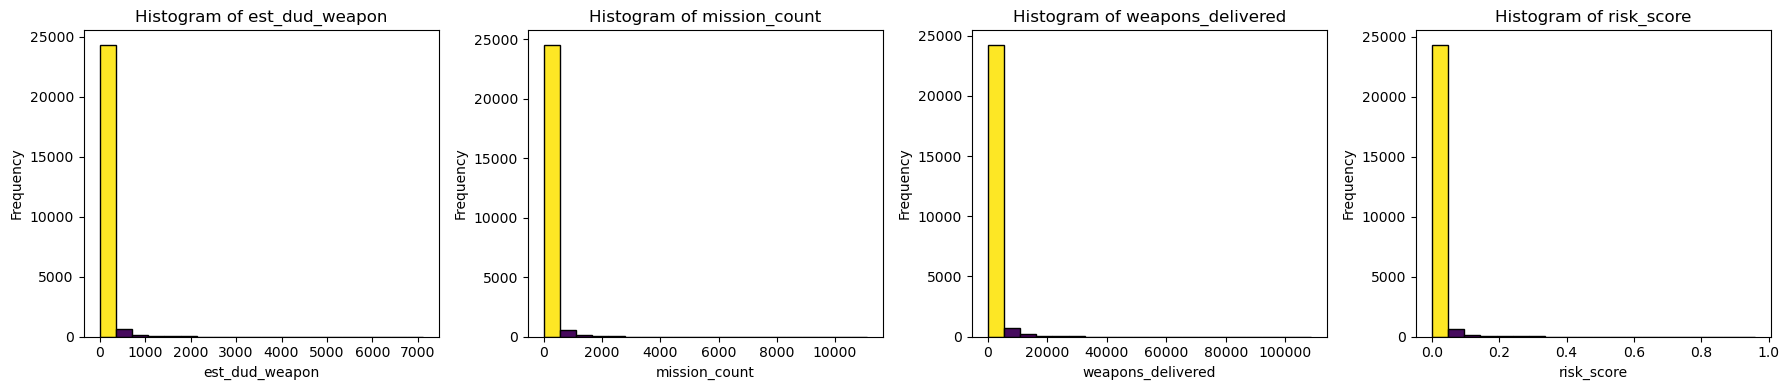

In [38]:
import matplotlib.pyplot as plt
import numpy as np

columns = ['est_dud_weapon', 'mission_count', 'weapons_delivered', 'risk_score']

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

cmap = plt.cm.viridis  # heat colormap

for ax, col in zip(axes, columns):
    counts, bins, patches = ax.hist(risk_table[col].dropna(), bins=20, edgecolor='black')

    norm = plt.Normalize(min(counts), max(counts))
    for count, patch in zip(counts, patches):
        patch.set_facecolor(cmap(norm(count)))

    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Initially I intended to classify risk areas based on number ob weapons dropped or dud weapons but since most areas have bombs, it is better to classify areas based on priority, which areas have more risk than otheres, for this reason I will use quantile based classification.

  Quantile  Lower Bound  Upper Bound
0       Q1     0.000000     0.000150
1       Q2     0.000150     0.000579
2       Q3     0.000579     0.001616
3       Q4     0.001616     0.004147
4       Q5     0.004147     0.012328
5       Q6     0.012328     0.959595


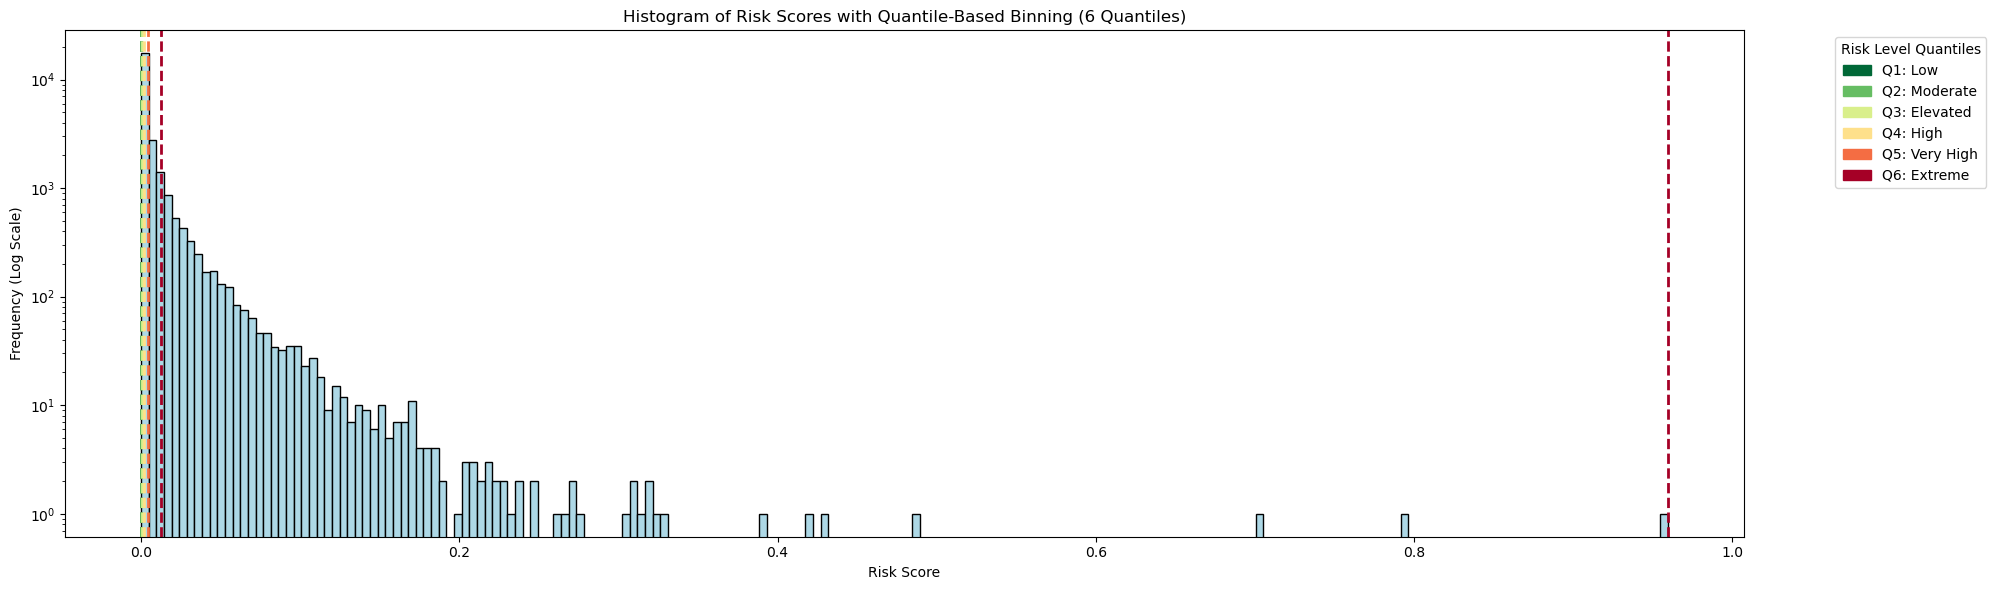

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

# Get risk scores
risk_scores = risk_table['risk_score'].values

# Use arbitrary binning for histogram
bins = 200

# Compute quantile breakpoints (6 quantiles = 5 cuts)
n_classes = 6
quantile_edges = np.quantile(risk_scores, np.linspace(0, 1, n_classes + 1))

# Create quantile bin ranges
quantile_ranges = []
for i in range(len(quantile_edges) - 1):
    quantile_ranges.append({
        'Quantile': f'Q{i + 1}',
        'Lower Bound': quantile_edges[i],
        'Upper Bound': quantile_edges[i + 1]
    })
quantile_df = pd.DataFrame(quantile_ranges)
print(quantile_df)

# Plot histogram
plt.figure(figsize=(20, 6))
plt.hist(risk_scores, bins=bins, color='lightblue', edgecolor='black')

# Logarithmic scale on the y-axis
plt.yscale('log')

# Colormap
cmap = matplotlib.colormaps['RdYlGn_r'].resampled(n_classes)

# Plot vertical lines for quantile boundaries
for i, q in enumerate(quantile_edges):
    plt.axvline(q, color=cmap(i), linestyle='--', linewidth=2)

# Legend
risk_levels = ['Low', 'Moderate', 'Elevated', 'High', 'Very High', 'Extreme']
patches = [
    mpatches.Patch(color=cmap(i), label=f'Q{i + 1}: {risk_levels[i]}')
    for i in range(n_classes)
]
plt.legend(handles=patches, title='Risk Level Quantiles', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Histogram of Risk Scores with Quantile-Based Binning (6 Quantiles)')
plt.xlabel('Risk Score')
plt.ylabel('Frequency (Log Scale)')
plt.tight_layout()
plt.show()


  Quantile  Lower Bound  Upper Bound
0       Q1     0.000000     0.000150
1       Q2     0.000150     0.000579
2       Q3     0.000579     0.001616
3       Q4     0.001616     0.004147
4       Q5     0.004147     0.012328
5       Q6     0.012328     0.959595


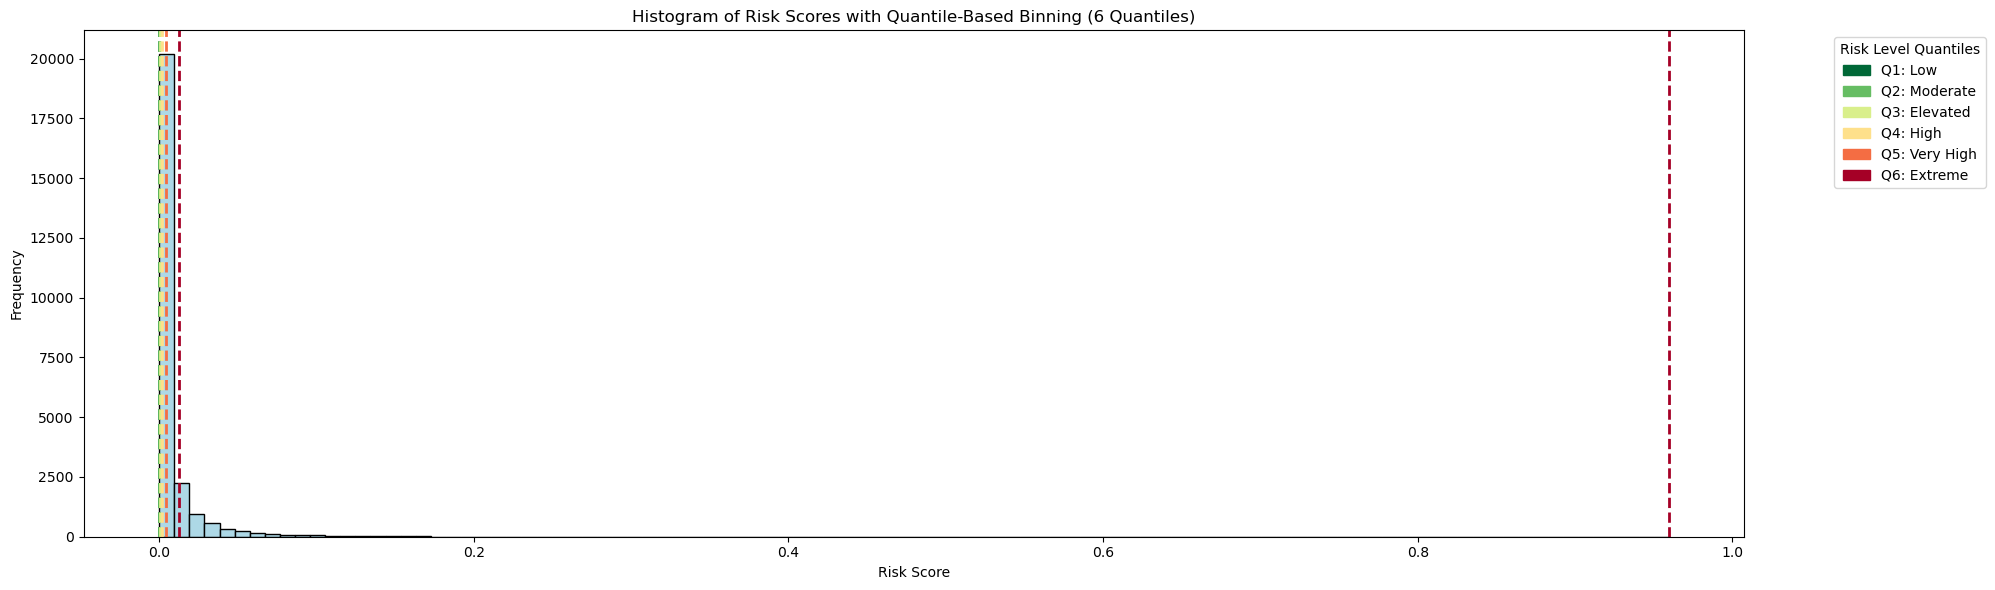

In [40]:
# Get risk scores
risk_scores = risk_table['risk_score'].values

# Use arbitrary binning for histogram
bins = 100

# Compute quantile breakpoints (6 quantiles = 5 cuts)
n_classes = 6
quantile_edges = np.quantile(risk_scores, np.linspace(0, 1, n_classes + 1))

# Create quantile bin ranges
quantile_ranges = []
for i in range(len(quantile_edges)-1):
    quantile_ranges.append({
        'Quantile': f'Q{i+1}',
        'Lower Bound': quantile_edges[i],
        'Upper Bound': quantile_edges[i+1]
    })
quantile_df = pd.DataFrame(quantile_ranges)
print(quantile_df)

# Plot histogram
plt.figure(figsize=(20, 6))
plt.hist(risk_scores, bins=bins, color='lightblue', edgecolor='black')

# Colormap
cmap = matplotlib.colormaps['RdYlGn_r'].resampled(n_classes)

# Plot vertical lines for quantile boundaries
for i, q in enumerate(quantile_edges):
    plt.axvline(q, color=cmap(i), linestyle='--', linewidth=2)

# Legend
risk_levels = ['Low', 'Moderate', 'Elevated', 'High', 'Very High', 'Extreme']
patches = [
    mpatches.Patch(color=cmap(i), label=f'Q{i+1}: {risk_levels[i]}')
    for i in range(n_classes)
]
plt.legend(handles=patches, title='Risk Level Quantiles', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Histogram of Risk Scores with Quantile-Based Binning (6 Quantiles)')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [41]:
area_per_cell_km2 = 10

bin_edges = quantile_edges

quantile_indices = np.digitize(risk_scores, bin_edges, right=False) - 1

quantile_indices = np.clip(quantile_indices, 0, len(risk_levels) - 1)

counts = np.bincount(quantile_indices, minlength=len(risk_levels))

areas_km2 = counts * area_per_cell_km2

area_df = pd.DataFrame({
    'Quantile': [f'Q{i+1}' for i in range(len(risk_levels))],
    'Risk Level': risk_levels,
    'Grid Count': counts,
    'Area (km²)': areas_km2
})

print(area_df)

  Quantile Risk Level  Grid Count  Area (km²)
0       Q1        Low        4192       41920
1       Q2   Moderate        4223       42230
2       Q3   Elevated        4207       42070
3       Q4       High        4208       42080
4       Q5  Very High        4207       42070
5       Q6    Extreme        4208       42080


#### Mapping risk level into risk table

In [50]:
risk_levels = ['Low', 'Moderate', 'Elevated', 'High', 'Very High', 'Extreme']

quantile_indices = np.digitize(risk_table['risk_score'], bin_edges, right=False) - 1
quantile_indices = np.clip(quantile_indices, 0, len(risk_levels) - 1)

risk_table['risk_level'] = [risk_levels[i] for i in quantile_indices]

level_3_stats = risk_table
risk_table.head(5)

,grid_id,est_dud_weapon,mission_count,weapons_delivered,ADM1_name,ADM1_id,ADM2_name,ADM2_id,grid_center_lon,grid_center_lat,risk_score,risk_level
0,100_729,0.00,1,0,Sơn La,63759600B3920147428024,Sop Cop,81297802B35904575630157,103.248875,20.853103,0.000000,Low
1,100_731,0.00,2,0,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.248213,20.910223,0.000030,Low
2,100_732,28.48,13,338,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.247881,20.938783,0.002733,High
3,100_737,0.00,3,0,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.246212,21.081582,0.000060,Low
4,100_740,0.60,3,6,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.245204,21.167260,0.000107,Low


In [43]:
# level_3_stats.to_csv('analysis/data/level3-grid-risk.csv', index=False)

## 2.3. Level 2 Risk Assessment / ADM2 Level Assessment
- Count of squares with high risk = weighted count of squares with different risks. Because mean score doesn't reflect priority very well
- Estimated UXO count
- Average score of 10km2s

In [53]:
adm2_group = risk_table.groupby('ADM2_id')

#### Weighted count of squares with different risks

In [74]:
normalization = 1 + 2 + 3 + 4 + 5 + 6
risk_level_weights = {
    'Low': 1 / normalization,
    'Moderate': 2 / normalization,
    'Elevated': 3 / normalization,
    'High': 4 / normalization,
    'Very High': 5 / normalization,
    'Extreme': 6 / normalization
}

risk_table['risk_weight'] = risk_table['risk_level'].map(risk_level_weights)

adm2_stats = risk_table.groupby('ADM2_id').agg(
    grid_count=('grid_id', 'count'),
    estimated_uxo=('est_dud_weapon', 'sum'),
    weighted_risk_score=('risk_weight', 'sum'),
    average_risk_score=('risk_score', 'mean'),
    mission_density=('mission_count', 'sum'),
    weapons_density=('weapons_delivered', 'sum')
).reset_index()

adm2_stats['weighted_avg_risk_level'] = adm2_stats['weighted_risk_score'] / adm2_stats['grid_count']

In [75]:
geo_data_adm2 = operations_with_grid_clean[
    ['ADM1_name', 'ADM1_id', 'ADM2_name', 'ADM2_id']
].drop_duplicates(subset='ADM2_id')

adm2_stats = adm2_stats.merge(geo_data_adm2, how='left', on='ADM2_id')

In [76]:
adm2_stats.head(5)

,ADM2_id,grid_count,estimated_uxo,weighted_risk_score,average_risk_score,mission_density,weapons_density,weighted_avg_risk_level,ADM1_name,ADM1_id,ADM2_name
0,81297802B10167820950608,50,78.605,4.238095,0.000376,277,2697,0.084762,Bắc Giang,63759600B37262939240335,Son Dong
1,81297802B1021983329449,24,51.105,2.047619,0.000359,106,1221,0.085317,Cần Thơ,63759600B21046589863912,Co Do
2,81297802B10372149063277,56,1248.560,10.047619,0.003480,2319,22260,0.179422,Bình Thuận,63759600B31473825670333,Duc Linh
3,81297802B1045120286230,3,64.936,0.666667,0.005357,324,1101,0.222222,Quảng Ngãi,63759600B52816170319692,Quang Ngai
4,81297802B10550571931229,1,0.000,0.047619,0.000030,2,0,0.047619,NaN,NaN,Kien Hai


In [77]:
adm2_subset = adm2[['shapeID', 'geometry']].rename(columns={'shapeID': 'ADM2_id'})
adm2_stats = adm2_stats.merge(adm2_subset, how='left', on='ADM2_id')

In [78]:
adm2_stats['weighted_avg_risk_level'].describe()

count    676.000000
mean       0.157327
std        0.068930
min        0.047619
25%        0.095238
50%        0.152920
75%        0.216057
max        0.285714
Name: weighted_avg_risk_level, dtype: float64

### weighted_avg_risk_level
This is preferred because:
- It takes into account both the quantity and severity of high-risk grids.
- It reflects how concentrated the higher-risk zones are in the ADM2 unit.
- It's based on ordinal risk levels (Low → Extreme) rather than raw scores, which helps avoid distortion from outliers.

| Metric                    | Pros                                                               | Cons                                                                |
| ------------------------- | ------------------------------------------------------------------ | ------------------------------------------------------------------- |
| `average_risk_score`      | Captures raw model output average                                  | Highly skewed by outliers due to exponential-like risk distribution |
| `weighted_avg_risk_level` | Respects **human-meaningful categories**, robust to extreme values | Depends on quality of your quantile binning                         |


In [81]:
bins = [0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.1]  # Slightly above max

labels = ['Low', 'Moderate', 'Elevated', 'High', 'Very High', 'Extreme']

adm2_stats['adm2_risk'] = pd.cut(adm2_stats['weighted_avg_risk_level'], bins=bins, labels=labels)

array([0, 1, 2, 3, 4, 5, 6])

In [82]:
adm2_stats.head(1)

,ADM2_id,grid_count,estimated_uxo,weighted_risk_score,average_risk_score,mission_density,weapons_density,weighted_avg_risk_level,ADM1_name,ADM1_id,ADM2_name,geometry,adm2_risk
0,81297802B10167820950608,50,78.605,4.238095,0.000376,277,2697,0.084762,Bắc Giang,63759600B37262939240335,Son Dong,"POLYGON ((107.03241 21.32525, 107.03208 21.325...",Low


In [87]:
adm2_stats['adm2_risk'].value_counts()

adm2_risk
Low          676
Moderate       0
Elevated       0
High           0
Very High      0
Extreme        0
Name: count, dtype: int64

In [83]:
adm2_stats.to_csv('analysis/data/level2-adm2-risk.csv', index=False)

## 2.4. Level 1 Risk Assessment / ADM0 Risk Assessment

#### Assessing level 1:
- Using level 2 data only -> Might miss some high risk areas, miss granularity
- Using ADM1 -> 10km2 grids -> High accuracy but might be less interpretable, and practically ADM2 is the regions given authority to act
- Solution: Use both
    + Numerical values uses 10km2 directly (for more accuracy)
    + Summary data uses ADM2 for majority vote
- Risk_level: Majority vote over ADM2
- Estimated_uxo: 10km2
- Weighted_risk_score: 10km2
- Mission_density: 10km2

In [84]:
level_3_stats.head(5)

,grid_id,est_dud_weapon,mission_count,weapons_delivered,ADM1_name,ADM1_id,ADM2_name,ADM2_id,grid_center_lon,grid_center_lat,risk_score,risk_level,risk_weight,weighted_risk_score
0,100_729,0.00,1,0,Sơn La,63759600B3920147428024,Sop Cop,81297802B35904575630157,103.248875,20.853103,0.000000,Low,0.047619,0.000000
1,100_731,0.00,2,0,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.248213,20.910223,0.000030,Low,0.047619,0.000030
2,100_732,28.48,13,338,Điện Biên,63759600B72990231521734,Dien Bien,81297802B1284717956892,103.247881,20.938783,0.002733,High,0.190476,0.010933
3,100_737,0.00,3,0,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.246212,21.081582,0.000060,Low,0.047619,0.000060
4,100_740,0.60,3,6,Điện Biên,63759600B72990231521734,Dien Bien Dong,81297802B35707987060986,103.245204,21.167260,0.000107,Low,0.047619,0.000107


In [85]:
adm2_stats.head(1)

,ADM2_id,grid_count,estimated_uxo,weighted_risk_score,average_risk_score,mission_density,weapons_density,weighted_avg_risk_level,ADM1_name,ADM1_id,ADM2_name,geometry,adm2_risk
0,81297802B10167820950608,50,78.605,4.238095,0.000376,277,2697,0.084762,Bắc Giang,63759600B37262939240335,Son Dong,"POLYGON ((107.03241 21.32525, 107.03208 21.325...",Low


In [86]:
adm1_group = adm2_stats.groupby('ADM1_id')
grouped_adm2_risk = adm1_group['adm2_risk'].value_counts()

In [240]:

# STEP 1: Majority Vote over ADM2 Risk Levels
adm2_vote = (
    adm2_stats.groupby(['ADM1_id', 'adm2_risk'], observed=True)
    .size()
    .unstack(fill_value=0)
)

# Majority vote: pick risk level with highest count
adm2_vote['risk_level'] = adm2_vote.idxmax(axis=1)

# Reset index to turn into a usable DataFrame
adm2_vote = adm2_vote.reset_index()[['ADM1_id', 'risk_level']]

# STEP 2: Aggregate Numerical Values from 10km²
adm1_numerical = (
    level_3_stats.groupby('ADM1_id')
    .agg(
        estimated_uxo=('est_dud_weapon', 'sum'),
        weighted_risk_score=('risk_score', 'mean'),  # or weighted mean if needed
        mission_density=('mission_count', 'mean')    # or sum if appropriate
    )
    .reset_index()
)

# STEP 3: Hotspot Flag (≥25% grids are High or Extreme)
high_risk_mask = level_3_stats['risk_level'].isin(['High', 'Extreme'])

total_grids = level_3_stats.groupby('ADM1_id').size().rename('total_grids')
high_risk_grids = level_3_stats[high_risk_mask].groupby('ADM1_id').size().rename('high_risk_grids')

hotspot_df = pd.concat([total_grids, high_risk_grids], axis=1).fillna(0)
hotspot_df['high_risk_ratio'] = hotspot_df['high_risk_grids'] / hotspot_df['total_grids']
hotspot_df['is_hotspot'] = hotspot_df['high_risk_ratio'] > 0.25
hotspot_df = hotspot_df[['is_hotspot']].reset_index()

# STEP 4: Combine All Into ADM1 Summary-
adm1_stats = adm1_numerical \
    .merge(adm2_vote, on='ADM1_id', how='left') \
    .merge(hotspot_df, on='ADM1_id', how='left')

In [241]:
adm1_geo_data = operations_with_grid_clean[
    ['ADM1_name', 'ADM1_id']
].drop_duplicates(subset='ADM1_id')

In [242]:
adm1_trimmed = adm1_geo_data[adm1_geo_data['ADM1_id'].isin(adm1_stats['ADM1_id'])]
adm1_stats = adm1_stats.merge(adm1_trimmed, on='ADM1_id', how='left')

In [243]:
adm1_stats.head(5)

,ADM1_id,estimated_uxo,weighted_risk_score,mission_density,risk_level,is_hotspot,ADM1_name
0,63759600B11108179203280,1.836,0.000082,2.909091,Low,False,Cao Bằng
1,63759600B12588044805894,24782.171,0.016468,195.671233,Low,False,Tiền Giang
2,63759600B12839449494422,34197.142,0.008533,97.245847,Low,False,Đồng Nai
3,63759600B13042736323456,69030.758,0.013608,126.298883,Low,False,Bình Phước
4,63759600B15361955936842,41452.212,0.004037,42.299486,Low,False,Gia Lai


In [244]:
adm1_stats.loc[adm1_stats['ADM1_name'] == 'Hà Nội\t', 'ADM1_name'] = 'Hà Nội'

In [245]:
adm1_stats.to_csv('analysis/data/level1-adm1-risk.csv', index=False)